# GP Applied to the Four-Parity Problem

This time we apply GP to a Three-Parity problem -- this has a different type and different operators, but the algorithm remains the same.

The code in this notebook is a bit tighter, that is, although slightly more difficult to read, it is a lot more reusable. First of all, here's a nice piece of code to widen our notebook to make to easier to read the output we get later on.

Install DEAP.

In [30]:
!pip install deap

In [31]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

Import our tools as before, except this time we also include **itertools** and **networks** which contain some nice iterative tools (for creating our test set) and graph drawing functionality, respectively.

In [32]:
import operator
import math
import random

import numpy

from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp

import matplotlib.pyplot as plt

import itertools
import networkx as nx



Set our Genetic Programming parameters.  Notice that these are virtually the same as the GA ones.

In [33]:
# Genetic Programming constants:
POPULATION_SIZE = 500
P_CROSSOVER = 0.9
P_MUTATION = 0.3
MAX_GENERATIONS = 50
HALL_OF_FAME_SIZE = 10


Set the random seed.

In [34]:
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

Here are some GP-specific constants. Keeping them together like this will make later editing easier.

In [35]:
MIN_TREE_HEIGHT = 3
MAX_TREE_HEIGHT = 5
LIMIT_TREE_HEIGHT = 17
MUT_MIN_TREE_HEIGHT = 0
MUT_MAX_TREE_HEIGHT = 2

Some problem constants. One nice thing about this problem is that it is of scalable difficulty, so we name make it more difficult simply by increasing the number of inputs.

In [36]:
NUM_INPUTS = 4
NUM_COMBINATIONS = 2 ** NUM_INPUTS

Here's our fitness function. This is a bit more involved than before as we first create all our test cases and then write a function to calculate the party error. We declare a wrapper function, **getCost** to make this code more resuable. This way we can change the fitness function and we only need to change the name in **getCost**.

In [37]:
# calculate the truth table of even parity check:
parityIn = list(itertools.product([0, 1], repeat=NUM_INPUTS))
parityOut = []

for row in parityIn:
    parityOut.append(sum(row) % 2)

# calculate the difference between the results of the
# generated function and the expected parity results:
def parityError(individual):
    func = toolbox.compile(expr=individual)
    return sum(func(*pIn) != pOut for pIn, pOut in zip(parityIn, parityOut))

# fitness measure:
def getCost(individual):
    return parityError(individual), # return a tuple

In [38]:
# Define the 3-bit parity problem
def parity4(x1, x2, x3, x4):
    return (x1 + x2 + x3 + x4) % 2 == 1

# Create a dataset for the problem
data_points = [(x1, x2, x3, x4, parity4(x1, x2, x3, x4)) for x1 in [0, 1] for x2 in [0, 1] for x3 in [0, 1] for x4 in [0,1]]
print(data_points)

[(0, 0, 0, 0, False), (0, 0, 0, 1, True), (0, 0, 1, 0, True), (0, 0, 1, 1, False), (0, 1, 0, 0, True), (0, 1, 0, 1, False), (0, 1, 1, 0, False), (0, 1, 1, 1, True), (1, 0, 0, 0, True), (1, 0, 0, 1, False), (1, 0, 1, 0, False), (1, 0, 1, 1, True), (1, 1, 0, 0, False), (1, 1, 0, 1, True), (1, 1, 1, 0, True), (1, 1, 1, 1, False)]


In [39]:
pset1 = gp.PrimitiveSet("PSET1", 4)
pset1.addPrimitive(operator.and_, 2)
pset1.addPrimitive(operator.or_, 2)
pset1.addPrimitive(operator.not_, 1)

pset2 = gp.PrimitiveSet("PSET2", 4)
pset2.addPrimitive(operator.and_, 2)
pset2.addPrimitive(operator.or_, 2)



def if_then_else(condition, out1, out2):
    return out1 if condition else out2

In [40]:

toolbox = base.Toolbox()

# define a single objective, minimizing fitness strategy:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))

# create the Individual class based on the primitive tree:
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

# create a helper function for creating random trees using the primitive set:
toolbox.register("expr", gp.genFull, pset=pset1, min_=MIN_TREE_HEIGHT, max_=MAX_TREE_HEIGHT)

# create the individual operator to fill up an Individual instance:
toolbox.register("individualCreator", tools.initIterate, creator.Individual, toolbox.expr)

# create the population operator to generate a list of individuals:
toolbox.register("populationCreator", tools.initRepeat, list, toolbox.individualCreator)

# create an operator to compile the primitive tree into python code:
toolbox.register("compile", gp.compile, pset=pset1)

toolbox.register("evaluate", getCost)

# genetic operators:
toolbox.register("select", tools.selTournament, tournsize=2)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genGrow, min_=MUT_MIN_TREE_HEIGHT, max_=MUT_MAX_TREE_HEIGHT)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset1)

# bloat control:
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=LIMIT_TREE_HEIGHT))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=LIMIT_TREE_HEIGHT))



/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Set up our population as before

In [41]:
population = toolbox.populationCreator(n=POPULATION_SIZE)
# define the hall-of-fame object:
hof = tools.HallOfFame(HALL_OF_FAME_SIZE)


Create a statistics object. This time we're going to use the **MultiStatistics** tool because we want to record statistics about **size** as well as **fitness**.

In [42]:
stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", numpy.mean)
mstats.register("std", numpy.std)
mstats.register("min", numpy.min)
mstats.register("max", numpy.max)


Run our GP. Notice how much slower this one is, due to the much larger population size.

In [43]:
population, logbook = algorithms.eaSimple(population,
                                                  toolbox,
                                                  cxpb=P_CROSSOVER,
                                                  mutpb=P_MUTATION,
                                                  ngen=MAX_GENERATIONS,
                                                  stats=mstats,
                                                  halloffame=hof,
                                                  verbose=True)

   	      	                    fitness                     	                      size                     
   	      	------------------------------------------------	-----------------------------------------------
gen	nevals	avg  	gen	max	min	nevals	std     	avg   	gen	max	min	nevals	std    
0  	500   	8.022	0  	10 	6  	500   	0.466386	19.562	0  	61 	4  	500   	11.5514
1  	456   	7.948	1  	9  	6  	456   	0.421065	19.494	1  	64 	1  	456   	12.6042
2  	468   	7.892	2  	10 	6  	468   	0.477845	20.146	2  	64 	1  	468   	13.5645
3  	452   	7.86 	3  	9  	6  	452   	0.469468	21.444	3  	67 	1  	452   	14.8109
4  	469   	7.862	4  	9  	6  	469   	0.476399	21.352	4  	78 	1  	469   	15.8324
5  	468   	7.806	5  	9  	6  	468   	0.477874	21.386	5  	90 	1  	468   	16.5026
6  	471   	7.798	6  	9  	6  	471   	0.530279	23.406	6  	75 	1  	471   	16.6683
7  	463   	7.736	7  	9  	6  	463   	0.574721	25.316	7  	78 	1  	463   	17.0574
8  	462   	7.69 	8  	9  	6  	462   	0.574369	27.35 	8  	78 	1  	462   	17

Extract our statistcs. This time our logbook has *chapters* because we have maintained multiple statistics.

-- Best Individual =  and_(or_(and_(and_(or_(or_(ARG3, and_(and_(ARG1, ARG2), or_(and_(or_(ARG3, ARG1), ARG1), or_(ARG3, ARG3)))), not_(ARG0)), or_(and_(ARG3, ARG0), or_(and_(ARG1, ARG1), and_(and_(or_(ARG1, or_(ARG3, not_(not_(ARG2)))), ARG2), or_(ARG3, not_(or_(not_(ARG3), or_(ARG2, not_(ARG3))))))))), or_(not_(and_(ARG3, or_(or_(ARG1, or_(or_(ARG3, ARG1), or_(or_(ARG2, ARG0), ARG3))), ARG0))), ARG2)), and_(or_(not_(and_(or_(or_(ARG3, ARG1), not_(ARG2)), or_(and_(ARG3, ARG0), and_(ARG2, ARG1)))), not_(ARG0)), and_(or_(ARG1, or_(ARG3, not_(not_(ARG0)))), not_(or_(ARG2, ARG1))))), or_(not_(and_(and_(or_(not_(not_(ARG3)), ARG1), or_(not_(not_(or_(and_(not_(and_(and_(ARG0, ARG2), ARG0)), or_(and_(and_(or_(or_(ARG1, ARG0), not_(ARG3)), not_(not_(ARG2))), ARG2), not_(or_(ARG1, not_(ARG3))))), and_(or_(and_(or_(ARG0, ARG3), and_(ARG1, ARG2)), not_(not_(ARG2))), or_(ARG1, ARG1))))), not_(or_(ARG2, or_(ARG1, ARG3))))), ARG2)), or_(and_(ARG1, ARG3), and_(and_(ARG2, or_(and_(or_(ARG3, ARG1), an

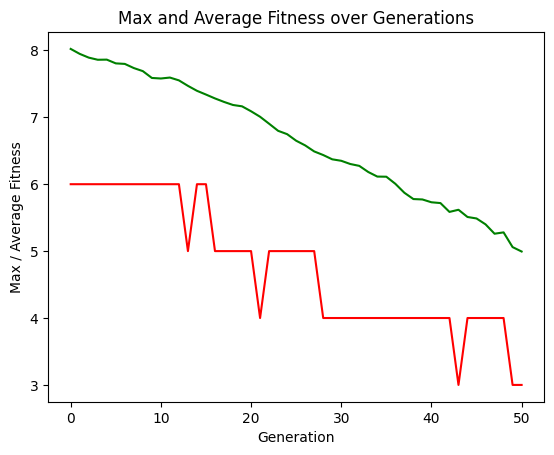

In [44]:
maxFitnessValues, meanFitnessValues = logbook.chapters['fitness'].select("min", "avg")


# print info for best solution found:
best1 = hof.items[0]
print("-- Best Individual = ", best1)
print("-- length={}, height={}".format(len(best1), best1.height))
print("-- Best Fitness = ", best1.fitness.values[0])

plt.plot(maxFitnessValues, color='red')
plt.plot(meanFitnessValues, color='green')
plt.xlabel('Generation')
plt.ylabel('Max / Average Fitness')
plt.title('Max and Average Fitness over Generations')
plt.show()

-- Best Individual =  and_(or_(and_(and_(or_(or_(ARG3, and_(and_(ARG1, ARG2), or_(and_(or_(ARG3, ARG1), ARG1), or_(ARG3, ARG3)))), not_(ARG0)), or_(and_(ARG3, ARG0), or_(and_(ARG1, ARG1), and_(and_(or_(ARG1, or_(ARG3, not_(not_(ARG2)))), ARG2), or_(ARG3, not_(or_(not_(ARG3), or_(ARG2, not_(ARG3))))))))), or_(not_(and_(ARG3, or_(or_(ARG1, or_(or_(ARG3, ARG1), or_(or_(ARG2, ARG0), ARG3))), ARG0))), ARG2)), and_(or_(not_(and_(or_(or_(ARG3, ARG1), not_(ARG2)), or_(and_(ARG3, ARG0), and_(ARG2, ARG1)))), not_(ARG0)), and_(or_(ARG1, or_(ARG3, not_(not_(ARG0)))), not_(or_(ARG2, ARG1))))), or_(not_(and_(and_(or_(not_(not_(ARG3)), ARG1), or_(not_(not_(or_(and_(not_(and_(and_(ARG0, ARG2), ARG0)), or_(and_(and_(or_(or_(ARG1, ARG0), not_(ARG3)), not_(not_(ARG2))), ARG2), not_(or_(ARG1, not_(ARG3))))), and_(or_(and_(or_(ARG0, ARG3), and_(ARG1, ARG2)), not_(not_(ARG2))), or_(ARG1, ARG1))))), not_(or_(ARG2, or_(ARG1, ARG3))))), ARG2)), or_(and_(ARG1, ARG3), and_(and_(ARG2, or_(and_(or_(ARG3, ARG1), an

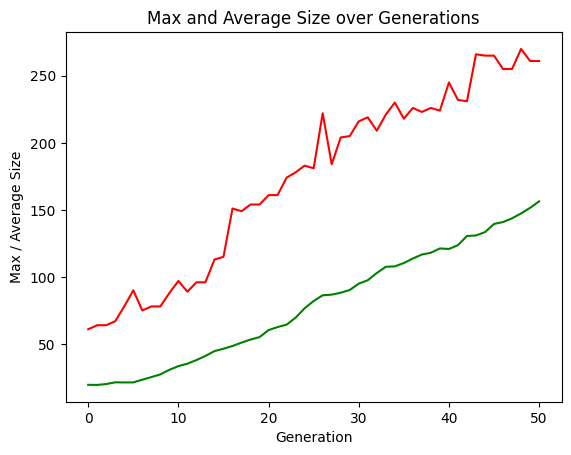

In [45]:
maxFitnessValues, meanFitnessValues = logbook.chapters['size'].select("max", "avg")


# print info for best solution found:
best1 = hof.items[0]
print("-- Best Individual = ", best1)
print("-- length={}, height={}".format(len(best1), best1.height))
print("-- Best Fitness = ", best1.fitness.values[0])

plt.plot(maxFitnessValues, color='red')
plt.plot(meanFitnessValues, color='green')
plt.xlabel('Generation')
plt.ylabel('Max / Average Size')
plt.title('Max and Average Size over Generations')
plt.show()

# Pset 2

In [46]:

toolbox = base.Toolbox()

# define a single objective, minimizing fitness strategy:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))

# create the Individual class based on the primitive tree:
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

# create a helper function for creating random trees using the primitive set:
toolbox.register("expr", gp.genFull, pset=pset2, min_=MIN_TREE_HEIGHT, max_=MAX_TREE_HEIGHT)

# create the individual operator to fill up an Individual instance:
toolbox.register("individualCreator", tools.initIterate, creator.Individual, toolbox.expr)

# create the population operator to generate a list of individuals:
toolbox.register("populationCreator", tools.initRepeat, list, toolbox.individualCreator)

# create an operator to compile the primitive tree into python code:
toolbox.register("compile", gp.compile, pset=pset2)

toolbox.register("evaluate", getCost)

# genetic operators:
toolbox.register("select", tools.selTournament, tournsize=2)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genGrow, min_=MUT_MIN_TREE_HEIGHT, max_=MUT_MAX_TREE_HEIGHT)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset2)

# bloat control:
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=LIMIT_TREE_HEIGHT))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=LIMIT_TREE_HEIGHT))

population = toolbox.populationCreator(n=POPULATION_SIZE)
# define the hall-of-fame object:
hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", numpy.mean)
mstats.register("std", numpy.std)
mstats.register("min", numpy.min)
mstats.register("max", numpy.max)

population, logbook = algorithms.eaSimple(population,
                                                  toolbox,
                                                  cxpb=P_CROSSOVER,
                                                  mutpb=P_MUTATION,
                                                  ngen=MAX_GENERATIONS,
                                                  stats=mstats,
                                                  halloffame=hof,
                                                  verbose=True)

maxFitnessValues, meanFitnessValues = logbook.chapters['fitness'].select("min", "avg")


# print info for best solution found:
best2 = hof.items[0]


/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


   	      	                    fitness                     	                      size                     
   	      	------------------------------------------------	-----------------------------------------------
gen	nevals	avg  	gen	max	min	nevals	std     	avg   	gen	max	min	nevals	std    
0  	500   	8.024	0  	11 	6  	500   	0.709524	35.672	0  	63 	15 	500   	19.7957
1  	448   	7.748	1  	10 	6  	448   	0.629679	34.372	1  	93 	1  	448   	20.874 
2  	464   	7.578	2  	9  	5  	464   	0.689867	36.152	2  	93 	1  	464   	21.1464
3  	466   	7.41 	3  	10 	5  	466   	0.752263	38.152	3  	97 	1  	466   	21.5644
4  	474   	7.294	4  	10 	5  	474   	0.763914	40.984	4  	115	1  	474   	21.8691
5  	473   	7.138	5  	9  	5  	473   	0.720386	45.276	5  	109	1  	473   	21.2591
6  	455   	6.98 	6  	9  	5  	455   	0.769155	49.62 	6  	111	1  	455   	20.4585
7  	466   	6.866	7  	9  	5  	466   	0.772039	52.304	7  	135	1  	466   	20.6362
8  	466   	6.704	8  	9  	5  	466   	0.802735	55.688	8  	135	1  	466   	20

-- Best Individual =  and_(or_(and_(and_(or_(ARG3, ARG0), and_(ARG3, or_(ARG3, ARG0))), and_(or_(or_(ARG1, ARG1), or_(ARG1, ARG0)), and_(and_(or_(ARG1, ARG1), ARG0), or_(ARG3, ARG0)))), and_(or_(and_(ARG1, ARG3), and_(ARG0, ARG2)), or_(and_(ARG2, ARG2), and_(ARG1, ARG2)))), or_(or_(or_(and_(ARG1, ARG2), ARG1), and_(and_(ARG2, ARG2), and_(ARG3, ARG3))), and_(or_(ARG3, and_(ARG3, ARG2)), ARG3)))
-- length=65, height=7
-- Best Fitness =  5.0


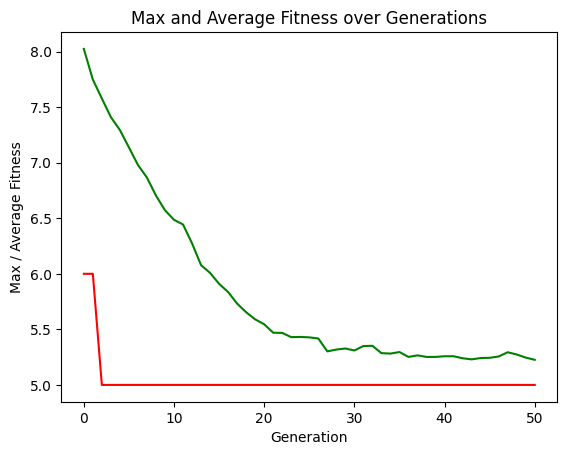

In [47]:
print("-- Best Individual = ", best2)
print("-- length={}, height={}".format(len(best2), best2.height))
print("-- Best Fitness = ", best2.fitness.values[0])

plt.plot(maxFitnessValues, color='red')
plt.plot(meanFitnessValues, color='green')
plt.xlabel('Generation')
plt.ylabel('Max / Average Fitness')
plt.title('Max and Average Fitness over Generations')
plt.show()

-- Best Individual =  and_(or_(and_(and_(or_(ARG3, ARG0), and_(ARG3, or_(ARG3, ARG0))), and_(or_(or_(ARG1, ARG1), or_(ARG1, ARG0)), and_(and_(or_(ARG1, ARG1), ARG0), or_(ARG3, ARG0)))), and_(or_(and_(ARG1, ARG3), and_(ARG0, ARG2)), or_(and_(ARG2, ARG2), and_(ARG1, ARG2)))), or_(or_(or_(and_(ARG1, ARG2), ARG1), and_(and_(ARG2, ARG2), and_(ARG3, ARG3))), and_(or_(ARG3, and_(ARG3, ARG2)), ARG3)))
-- length=190, height=7
-- Best Fitness =  3.0


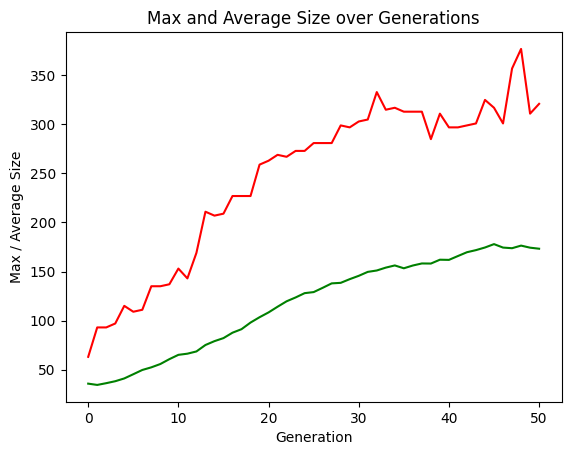

In [48]:
maxFitnessValues, meanFitnessValues = logbook.chapters['size'].select("max", "avg")


# print info for best solution found:
best2 = hof.items[0]
print("-- Best Individual = ", best2)
print("-- length={}, height={}".format(len(best1), best2.height))
print("-- Best Fitness = ", best1.fitness.values[0])

plt.plot(maxFitnessValues, color='red')
plt.plot(meanFitnessValues, color='green')
plt.xlabel('Generation')
plt.ylabel('Max / Average Size')
plt.title('Max and Average Size over Generations')
plt.show()